<a href="https://colab.research.google.com/github/GwiHwan-Go/Reproduce_CutMix/blob/main/Training/CutMix.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# !pip install torch
# !pip install torchvision
# !pip install pretrainedmodels

import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from torch.utils.data import Dataset
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import joblib
from tqdm.notebook import tqdm
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
########## YOUR DIR
import sys
sys.path.append("..") ## to import parent's folder
from Local import DIR 
########### YOUR DIR

## Read & Split data

In [2]:
from sklearn.model_selection import train_test_split

df_train = pd.read_csv(f"{DIR}/train.csv")
X_train, X_val = train_test_split(df_train, test_size=0.2)

## Define augmentations


In [3]:
import torch
import torchvision.transforms as T

train_augmentation = T.Compose([
    T.ToTensor(),
    T.RandomRotation(20),
    ##we can add more augmentation##
])

valid_augmentation = T.Compose([
    T.ToTensor(),
])

## Make model, optimizer and loss function - ResNet34

In [4]:
from torch.nn import Linear
import pretrainedmodels

model_name = 'resnet34'
model = pretrainedmodels.__dict__[model_name](pretrained='imagenet')

## 우리 이미지 사이즈에 맞게 튜닝
in_features = model.last_linear.in_features
model.last_linear = torch.nn.Linear(in_features, 186) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                      mode='max',
                                                      verbose=True,
                                                      patience=7,
                                                      factor=0.5)

cuda


## Define Dataset => Load with Data Loader

In [5]:
from torch.utils.data import Dataset, DataLoader

## Dataset Description : https://www.kaggle.com/competitions/bengaliai-cv19/data
class BengaliDataset(Dataset):
    def __init__(self, csv, img_height, img_width, transform):
        self.csv = csv.reset_index()
        self.img_ids = csv['image_id'].values
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        img_id = self.img_ids[index]
        img = joblib.load(f'{DIR}/train_images/{img_id}.pkl')
        img = img.reshape(self.img_height, self.img_width).astype(np.uint8)
        #img = 255 - img
        img = 255 - img
        #img = np.expand_dims(img, axis=2)
        img = img[:, :, np.newaxis]

        
        img = np.repeat(img, 3, 2)
        if self.transform is not None:
            img = self.transform(img)
        
        label_1 = self.csv.iloc[index].grapheme_root #-167
        label_2 = self.csv.iloc[index].vowel_diacritic #-10
        label_3 = self.csv.iloc[index].consonant_diacritic #-6
        
        return img, np.array([label_1, label_2, label_3])
        
train_dataset = BengaliDataset(csv=X_train,
                            img_height=137,
                            img_width=236,
                            transform=train_augmentation)
valid_dataset = BengaliDataset(csv=X_val,
                            img_height=137,
                            img_width=236,
                            transform=valid_augmentation)
train_loader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=128
                       )
valid_loader = DataLoader(valid_dataset,
                       shuffle=False,
                        num_workers=0,
                        batch_size=128
                       )

class labels: torch.Size([128, 3])


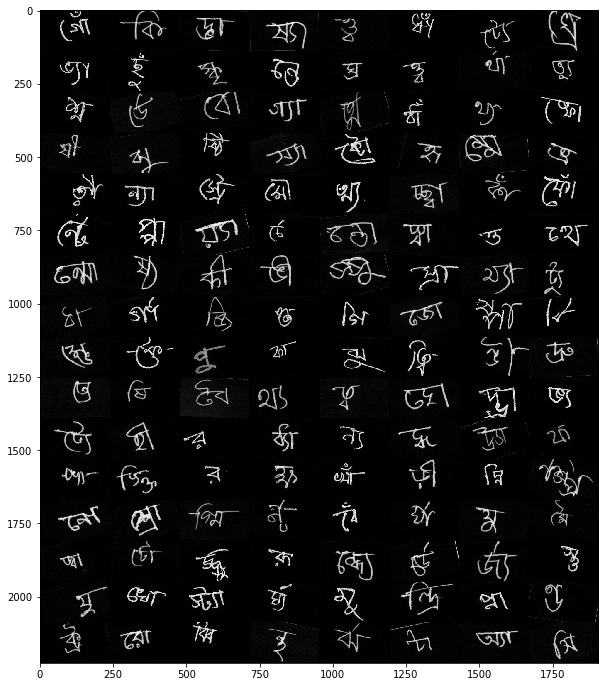

In [6]:
import torchvision
if device=="cpu" :
    os.environ["OMP_NUM_THREADS"]="1"  # If you are using CPU
batch = next(iter(train_loader))
images, labels = batch
plt.figure(figsize=(12,12))
print(f"class labels: {labels.shape}")


grid = torchvision.utils.make_grid(tensor=images, nrow=8)
plt.imshow(grid.permute(1,2,0))

## CutMix

In [7]:
def cut(W,H,lam):
        
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [8]:
targets_gra, targets_vow, targets_con = labels[:, 0], labels[:, 1], labels[:, 2]
rand_index = torch.randperm(images.size()[0])
lam = np.random.beta(1.0, 1.0)


shuffled_targets_gra = targets_gra[rand_index] #shape 128
shuffled_targets_vow = targets_vow[rand_index] #shape 128
shuffled_targets_con = targets_con[rand_index] #shape 128

print(f"targets_gra : {targets_gra[:5]}\ntargets_vow : {targets_vow[:5]}\ntargets_con : {targets_con[:5]}")

targets_gra : tensor([ 23,  13,  77, 139,  66])
targets_vow : tensor([9, 2, 1, 1, 0])
targets_con : tensor([1, 0, 0, 4, 0])


In [9]:
original_images = images.clone().detach() 
bbx1, bby1, bbx2, bby2 = cut(images.size()[2], images.size()[3], lam) # define a box to cut and mix
images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2] #cut and mix

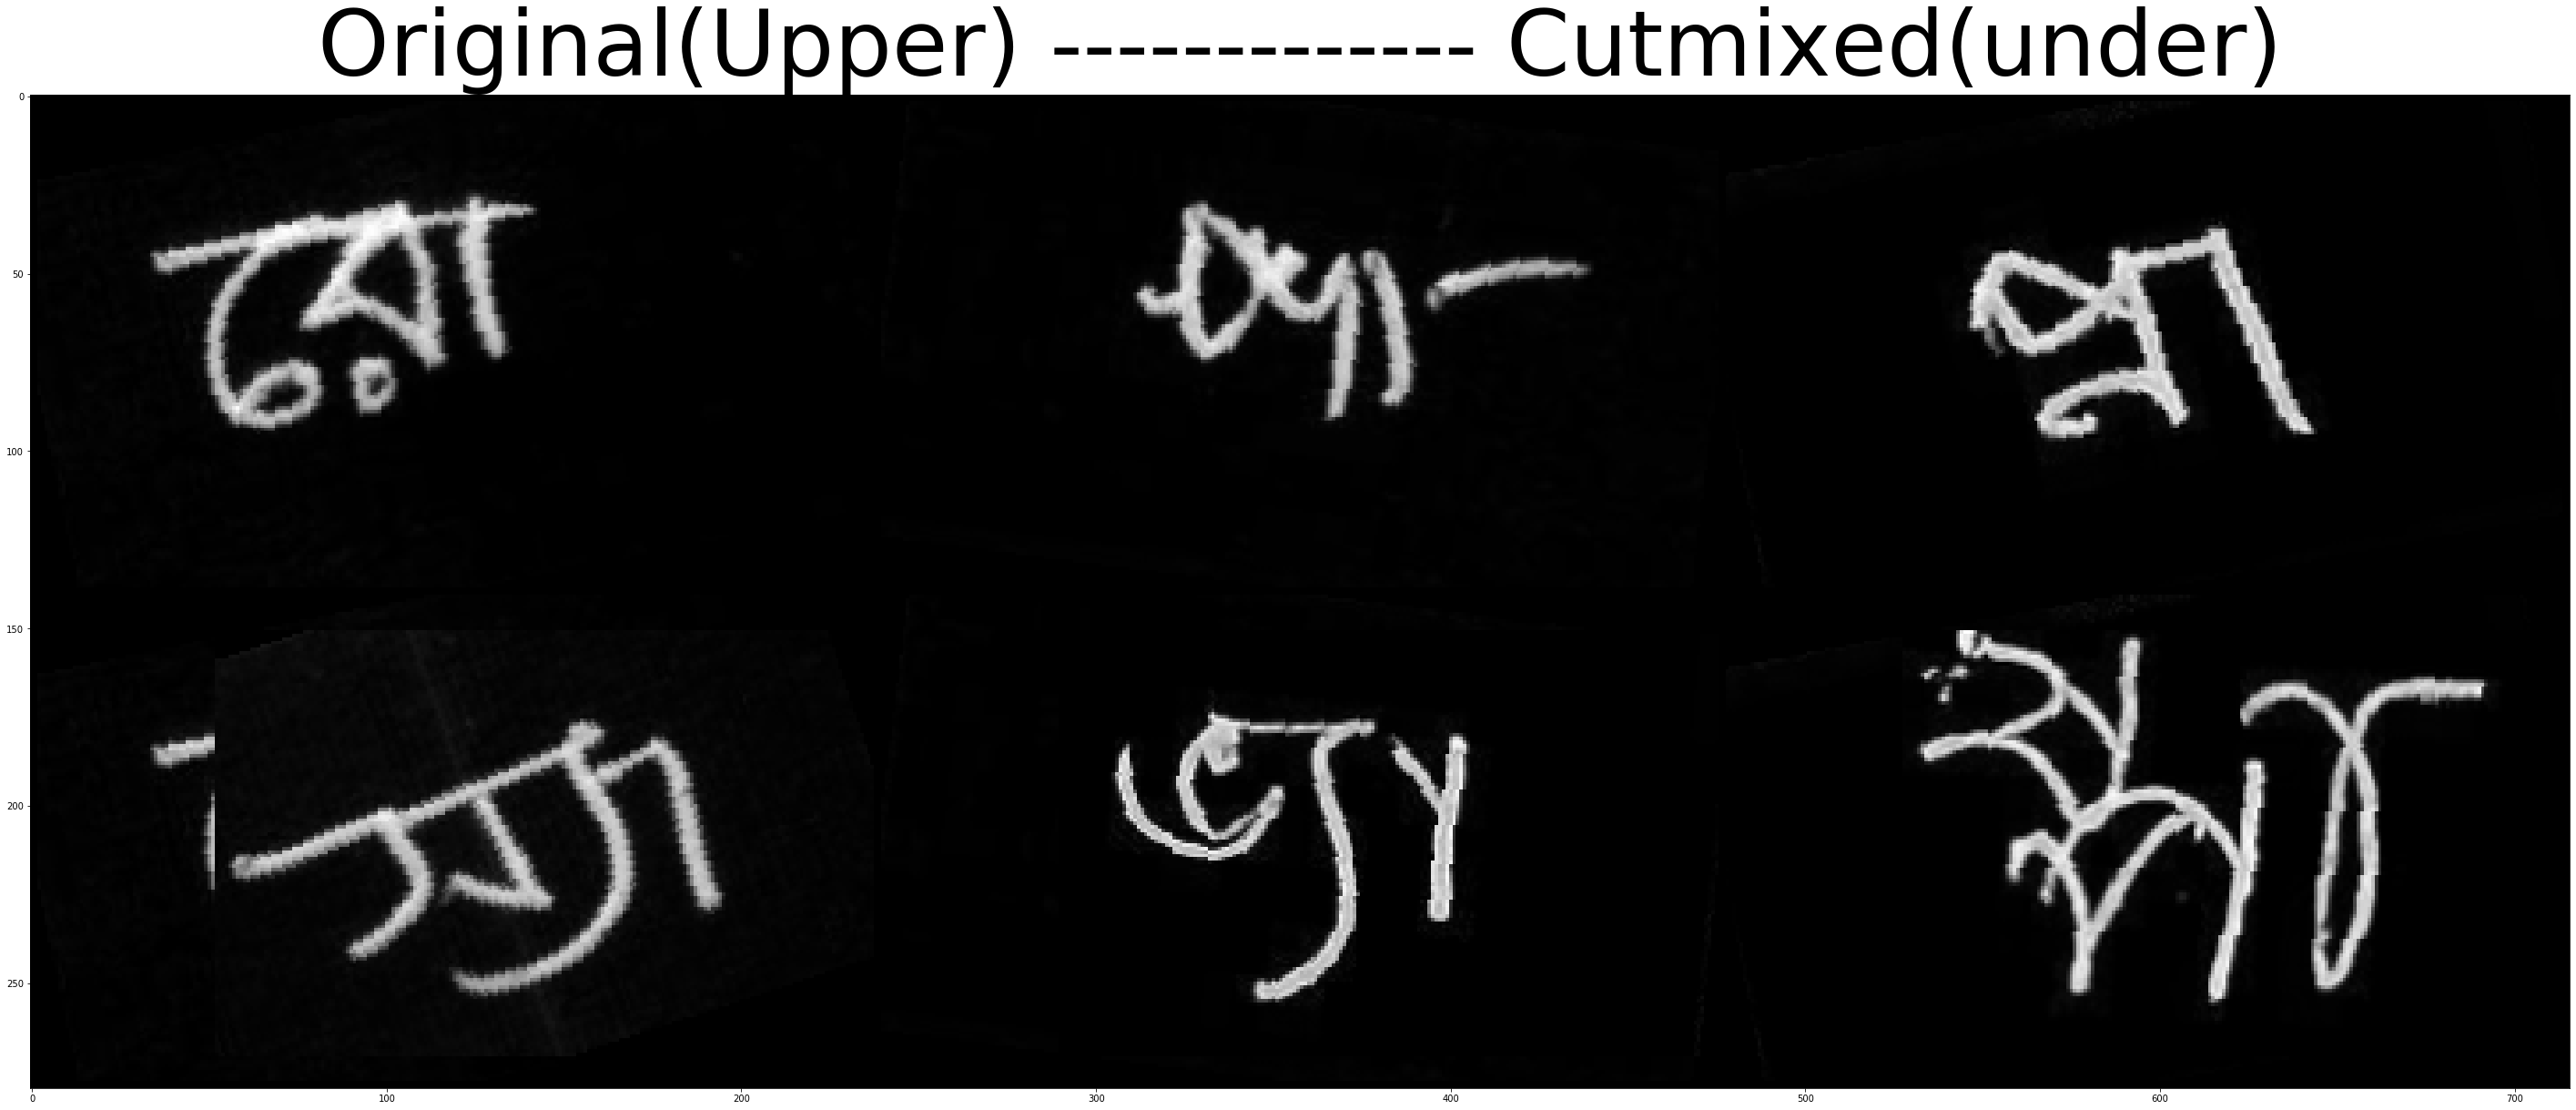

In [10]:
def show_cutMixed_compare(origin, new, nums_show):
    rand_index = torch.randperm(origin.size()[0])[:nums_show]
    to_compare = torch.cat([origin[rand_index,:,:],new[rand_index,:,:]],dim=0)
    plt.figure(figsize=(50,50))
    grid = torchvision.utils.make_grid(tensor=to_compare, nrow=nums_show)
    plt.title("Original(Upper) ------------- Cutmixed(under)", fontsize=100)
    plt.imshow(grid.permute(1,2,0))

show_cutMixed_compare(original_images, images, 3)

## Training

In [11]:
import os

out = model(images.to(device))
out_grapheme = out[:,:168]
out_vowel = out[:, 168:179]
out_cons = out[:, 179:]

In [12]:
out_grapheme = out[:,:168]
out_vowel = out[:, 168:179]
out_cons = out[:, 179:]

In [13]:
lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size()[-1] * images.size()[-2]))
loss1 = loss_fn(out_grapheme, targets_gra) * lam + loss_fn(out_grapheme, shuffled_targets_gra) * (1. - lam)
loss2 = loss_fn(out_vowel, targets_vow) * lam + loss_fn(out_vowel, shuffled_targets_vow) * (1. - lam)
loss3 = loss_fn(out_cons, targets_con) * lam + loss_fn(out_cons, shuffled_targets_con) * (1. - lam)
loss = 0.5 * loss1 + 0.25 * loss2 + 0.25 * loss3

RuntimeError: Expected object of device type cuda but got device type cpu for argument #2 'target' in call to _thnn_nll_loss_forward

In [15]:
for e in range(100):
    train_loss = []
    model.train()

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        if np.random.rand() < 0.5: # Implement cutMix 

            logits = model(images)
            grapheme = logits[:, :168]
            vowel = logits[:, 168:179]
            cons = logits[:, 179:]

            loss = loss_fn(grapheme, labels[:, 0]) + loss_fn(vowel, labels[:, 1]) + loss_fn(cons, labels[:, 2])

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.item())

        else:
            
            lam = np.random.beta(1.0, 1.0) 
            rand_index = torch.randperm(images.size()[0])
            
            targets_gra = labels[:, 0]
            targets_vow = labels[:, 1]
            targets_con = labels[:, 2]
            
            shuffled_targets_gra = targets_gra[rand_index]
            shuffled_targets_vow = targets_vow[rand_index]
            shuffled_targets_con = targets_con[rand_index]
            
            bbx1, bby1, bbx2, bby2 = cut(images.size()[2], images.size()[3], lam)
            images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size()[-1] * images.size()[-2]))
            
            logits = model(images) #forward pass

            grapheme = logits[:,:168] # output of grapheme
            vowel = logits[:, 168:179] # output of grapheme
            cons = logits[:, 179:] # output of grapheme
            
            loss1 = loss_fn(grapheme, targets_gra) * lam + loss_fn(grapheme, shuffled_targets_gra) * (1. - lam)
            loss2 = loss_fn(vowel, targets_vow) * lam + loss_fn(vowel, shuffled_targets_vow) * (1. - lam)
            loss3 = loss_fn(cons, targets_con) * lam + loss_fn(cons, shuffled_targets_con) * (1. - lam)
            
            loss = 0.5 * loss1 + 0.25 * loss2 + 0.25 * loss3
            
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.item())
            
            
    val_loss = []
    val_true = []
    val_pred = []

    model.eval()

    with torch.no_grad():
        for inputs, targets in tqdm(valid_loader):
            inputs = inputs.cuda()
            targets = targets.cuda()

            logits = model(inputs)

            grapheme = logits[:, :168]
            vowel = logits[:, 168:179]
            cons = logits[:, 179:]

            loss = loss_fn(grapheme, targets[:, 0]) + loss_fn(vowel, targets[:, 1]) + loss_fn(cons, targets[:, 2])

            val_loss.append(loss.item())

            grapheme = grapheme.cpu().argmax(dim=1).data.numpy()
            vowel = vowel.cpu().argmax(dim=1).data.numpy()
            cons = cons.cpu().argmax(dim=1).data.numpy()

            val_true.append(targets.cpu().numpy())
            val_pred.append(np.stack([grapheme, vowel, cons], axis=1))

    val_true = np.concatenate(val_true)
    val_pred = np.concatenate(val_pred)

    val_loss = np.mean(val_loss)
    train_loss = np.mean(train_loss)

    score_g = recall_score(val_true[:, 0], val_pred[:, 0], average='macro')
    score_v = recall_score(val_true[:, 1], val_pred[:, 1], average='macro')
    score_c = recall_score(val_true[:, 2], val_pred[:, 2], average='macro')

    final_score = np.average([score_g, score_v, score_c], weights=[2, 1, 1])

    print(f'train_loss: {train_loss:.5f}; val_loss: {val_loss:.5f}; score: {final_score:.5f}')
    print(f'score_g: {score_g:.5f}; score_v: {score_v: .5f}, score_c: {score_c: .5f}')


    if final_score > best_score:
        best_score = final_score

        state_dict = model.cpu().state_dict()
        model = model.cuda()
        torch.save(state_dict, "model.pt")

KeyboardInterrupt: 